In [2]:
import torch
import time
from data.num_solver_exciton import NZSolverEx
from data.num_solver_biexciton import NZSolverBiex
from data.noisy_data import gen_noisy_data
from train import train_nz_pinn
from estimator import train_inv_1, train_inv_2

Using device: cpu


Solving Nakajima-Zwanzig EOM for Exciton model: 100%|██████████| 1001/1001 [03:57<00:00,  4.21it/s]


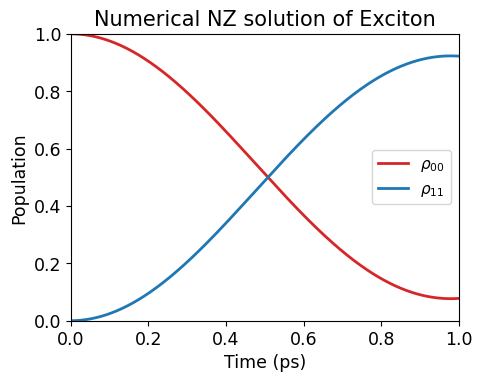

In [20]:
nz_ex = NZSolverEx(D=1,steps=1000,T=10)
times, rhos = nz_ex.solve(torch.tensor([[1.0, 0.0], [0.0, 0.0]], dtype=torch.cfloat))

rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])

# Plot dynamics
nz_ex.plot_results(times, rhos)

Solving Nakajima-Zwanzig EOM for Biexciton model: 100%|██████████| 1001/1001 [04:52<00:00,  3.43it/s]


Time taken: 292.1 seconds


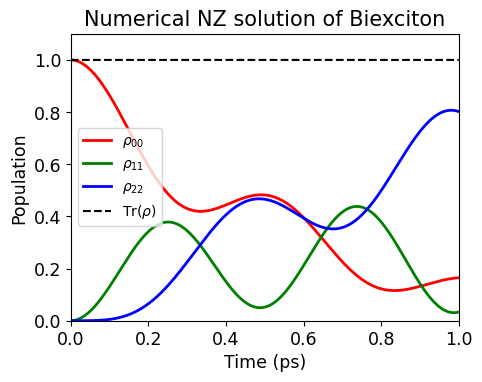

In [7]:
# Initial density matrix
rho_init = torch.diag(torch.tensor([1.0, 0.0, 0.0], dtype=torch.cfloat))

nz_biex = NZSolverBiex(D=1, steps=1000, alpha=0.126, omega_c=3.04, T=10)

start = time.time()
times, rhos = nz_biex.solve(rho_init)
end = time.time()
print(f"Time taken: {round(end - start, 1)} seconds")

# Plot dynamics
nz_biex.plot_results(times, rhos)

Epoch: 99  |  Loss = 9.50745e-04  |  RMSE = tensor([0.4193, 0.4193], dtype=torch.float64)


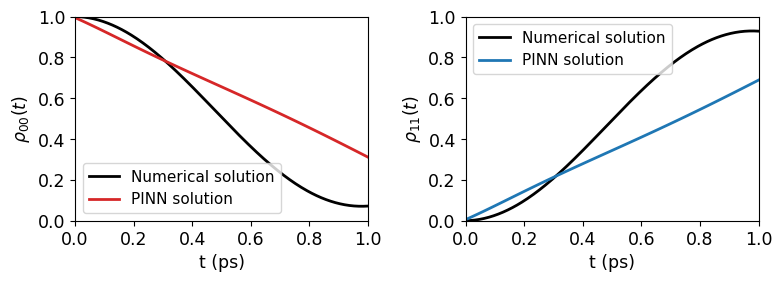

Epoch: 199  |  Loss = 4.68890e-04  |  RMSE = tensor([0.4297, 0.4297], dtype=torch.float64)


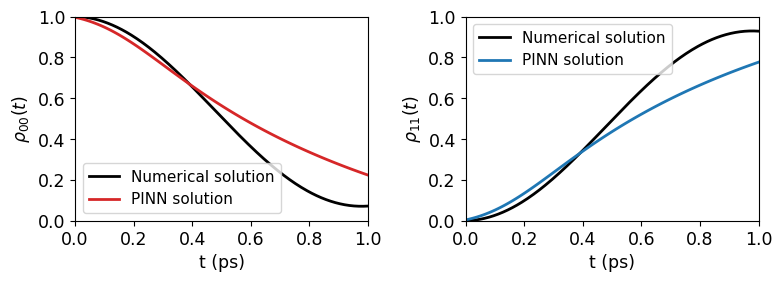

Epoch: 299  |  Loss = 1.19256e-04  |  RMSE = tensor([0.4547, 0.4547], dtype=torch.float64)


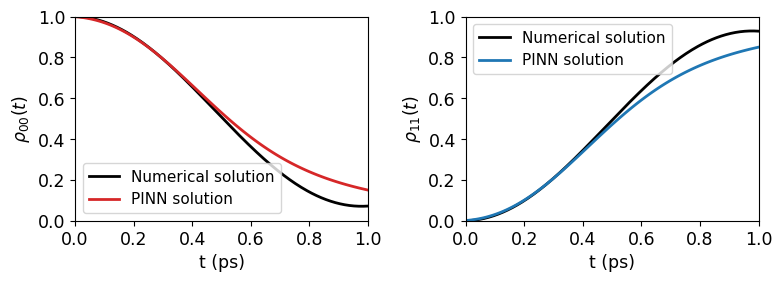

Epoch: 399  |  Loss = 4.99866e-05  |  RMSE = tensor([0.4632, 0.4632], dtype=torch.float64)


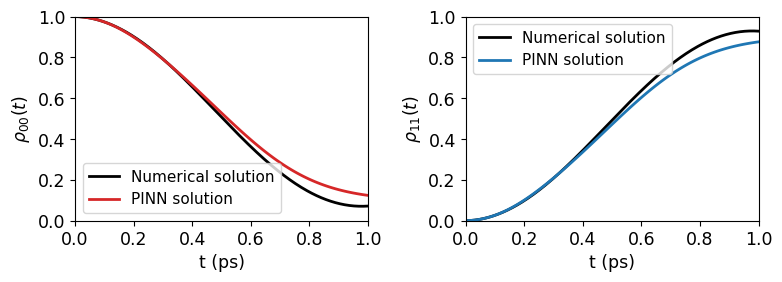

Epoch: 499  |  Loss = 1.78370e-05  |  RMSE = tensor([0.4722, 0.4722], dtype=torch.float64)


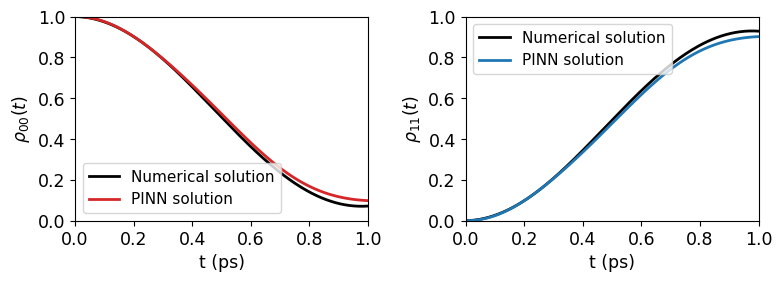

Epoch: 599  |  Loss = 8.96256e-06  |  RMSE = tensor([0.4741, 0.4741], dtype=torch.float64)


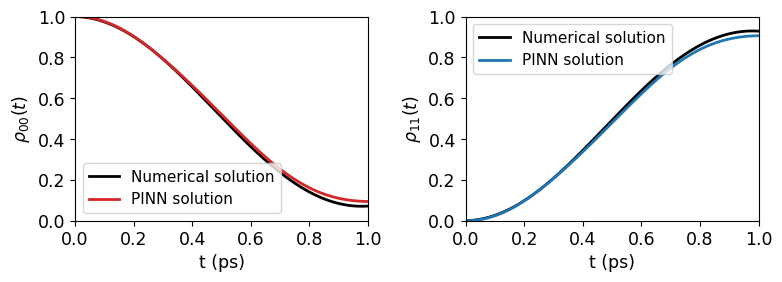

Epoch: 699  |  Loss = 4.98331e-06  |  RMSE = tensor([0.4750, 0.4750], dtype=torch.float64)


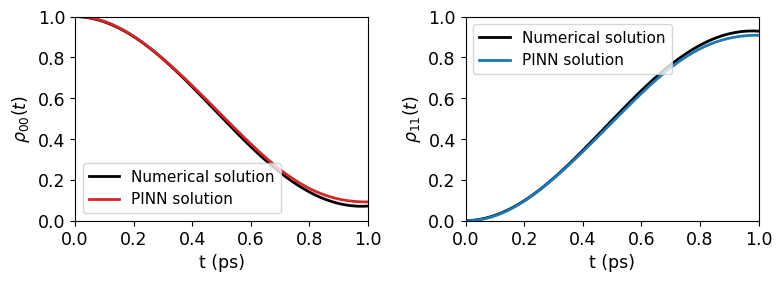

Time elapsed:  3.9992955684661866 min


In [6]:
# Diagonalize the numerically solved density matrices
rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])

start = time.time()
ex_model = train_nz_pinn(sys='e', t=times, rho_diag=rho_diag, D=1, t_intervals = 20, alpha=0.126, T=10, omega_c=3.04,
                    n_layers=4, n_hidden=32, epochs=700, lr=1e-2, lam=0.01, plot_interval=100)
end = time.time()

print(f"Time elapsed:  {(end-start)/60} min")

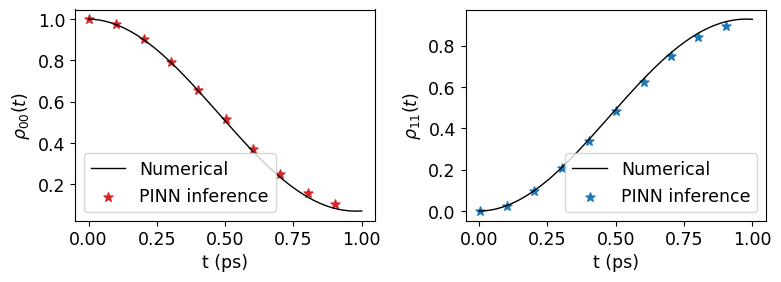

In [8]:
t_test = []
for i in range(0,len(times)-25,25):
    t_test.append((times[i]+times[i+1])/2)

t_test = torch.tensor(t_test, dtype=torch.float).view(-1,1)

with torch.no_grad():
    results = ex_model(t_test)

import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12.5

fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].plot(times, rho_diag[:,0], label="Numerical", color="black", linewidth=1)
axes[0].scatter(t_test, results[:, 0], label="PINN inference", color="tab:red", marker='*', s=45)
axes[0].set_xlabel("t (ps)")
axes[0].set_ylabel(r"$\rho_{00} (t)$")
#axes[0].set_ylim(0,1)
#axes[0].set_xlim(0,0.1)
axes[0].legend(loc='lower left')

axes[1].plot(times, rho_diag[:,1], label="Numerical", color="black", linewidth=1)
axes[1].scatter(t_test, 1-results[:, 0], label="PINN inference", color="tab:blue", marker='*', s=45)
axes[1].set_xlabel("t (ps)")
axes[1].set_ylabel(r"$\rho_{11} (t)$")
#axes[1].set_ylim(0,1)
#axes[1].set_xlim(0,0.1)
#axes[1].set_title(f"Epoch: {i},  loss = {round(loss.item(), 6)}")
axes[1].legend()

plt.tight_layout()
plt.show()


Epoch: 4599  |  Loss = 1.82971e-04  |  RMSE = tensor([0.3762, 0.1888, 0.3514], dtype=torch.float64)


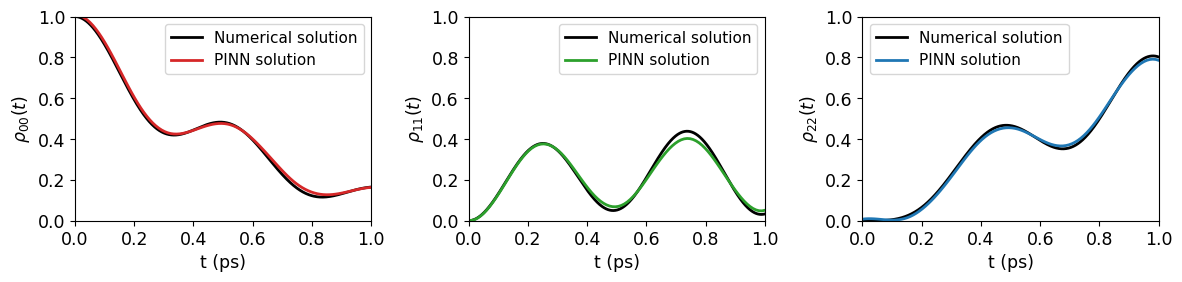

Time elapsed:  30.60522602001826 min


In [9]:
# Diagonalize the numerically solved density matrices
rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])
start = time.time()
biex_model = train_nz_pinn(sys='b', t=times, rho_diag=rho_diag, D=1, t_intervals=20, alpha=0.126, T=10, omega_c=3.04,
                    n_layers=4, n_hidden=32, epochs=4600, lr=1e-2, lam=0.01, plot_interval=4600)
end = time.time()
print(f"Time elapsed:  {(end-start)/60} min")

In [21]:
t_obs, rho_obs = gen_noisy_data(rhos, D=1, M=200, t_intervals=1001, scale=1e-2, seed=2025)

Epoch 0, Total Loss: 1.323678, PDE Loss: 3.659667, Data Loss: 1.287081, alpha = 0.9950000047683716


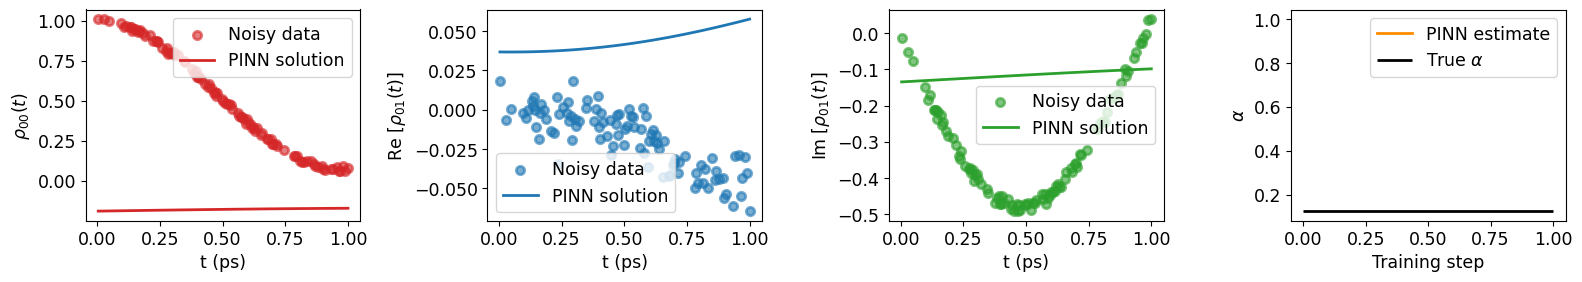

Epoch 100, Total Loss: 0.006686, PDE Loss: 0.285761, Data Loss: 0.003828, alpha = 0.6210697889328003


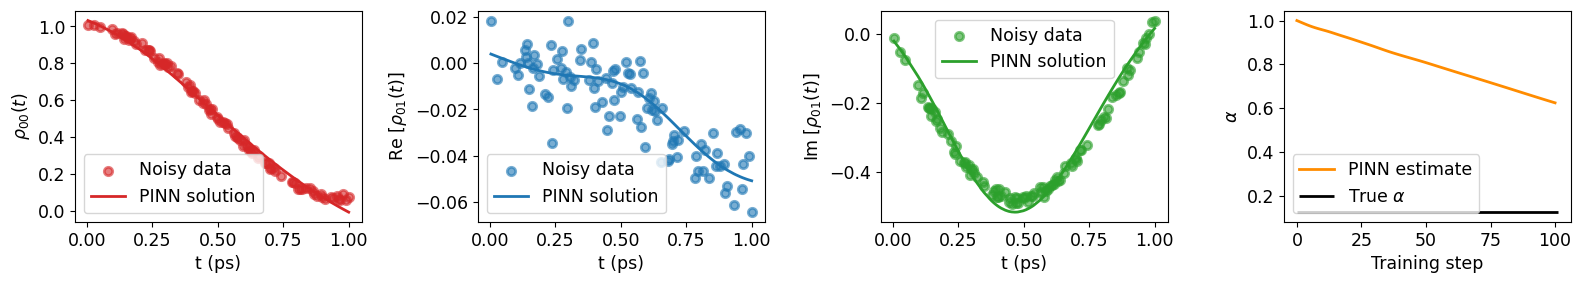

Epoch 200, Total Loss: 0.001947, PDE Loss: 0.067375, Data Loss: 0.001273, alpha = 0.32732126116752625


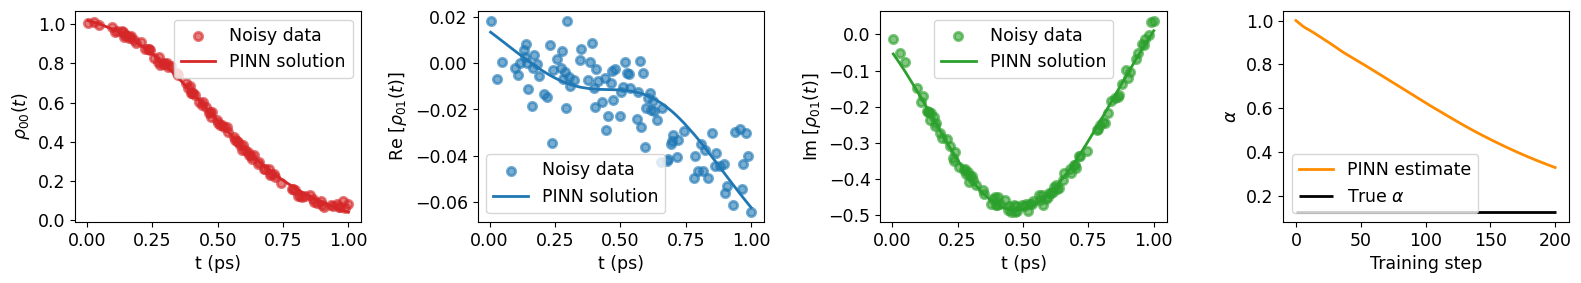

Epoch 300, Total Loss: 0.001333, PDE Loss: 0.018399, Data Loss: 0.001149, alpha = 0.1789827048778534


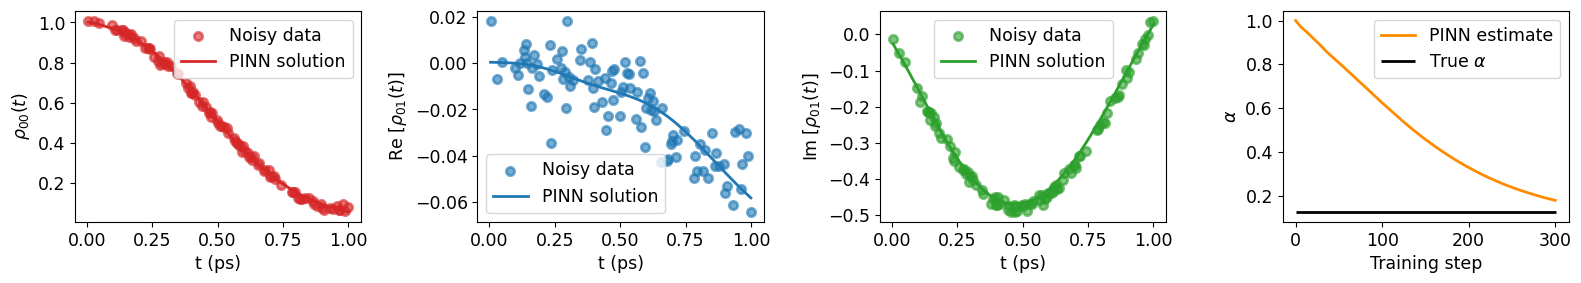

Epoch 400, Total Loss: 0.000947, PDE Loss: 0.008289, Data Loss: 0.000865, alpha = 0.12556372582912445


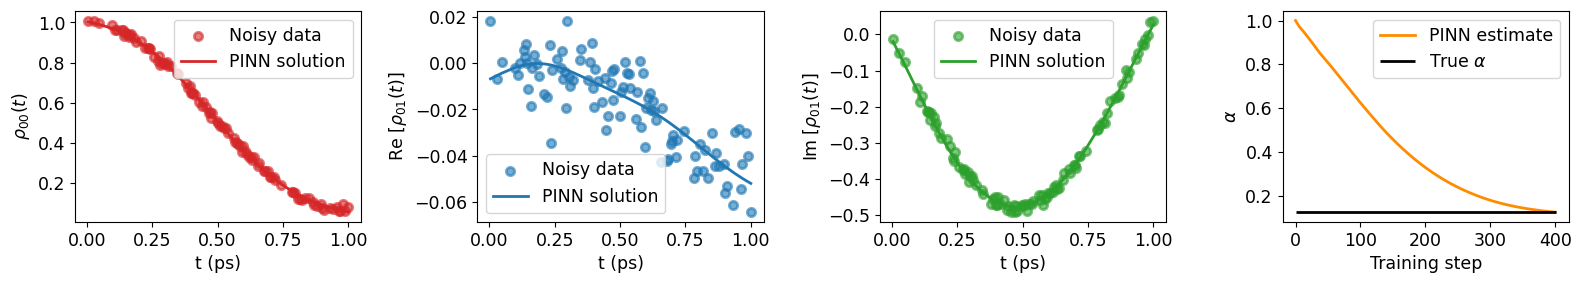

In [12]:
model_inv_1 = train_inv_1(t_obs, rho_obs, alpha0=0.126, v_c=3.04, D=1, T=10, t_intervals=20, M=100, 
                hidden_dim=32, num_layers=4, epochs=401, lr=5e-3, lam=1e-2, weight_decay=0,
                init_val=torch.tensor(1.0), plot_interval=100, seed=2025)

Epoch 0, Total Loss: 1.306231, PDE Loss: 2.136856, Data Loss: 1.284863, v_c = 4.005000114440918


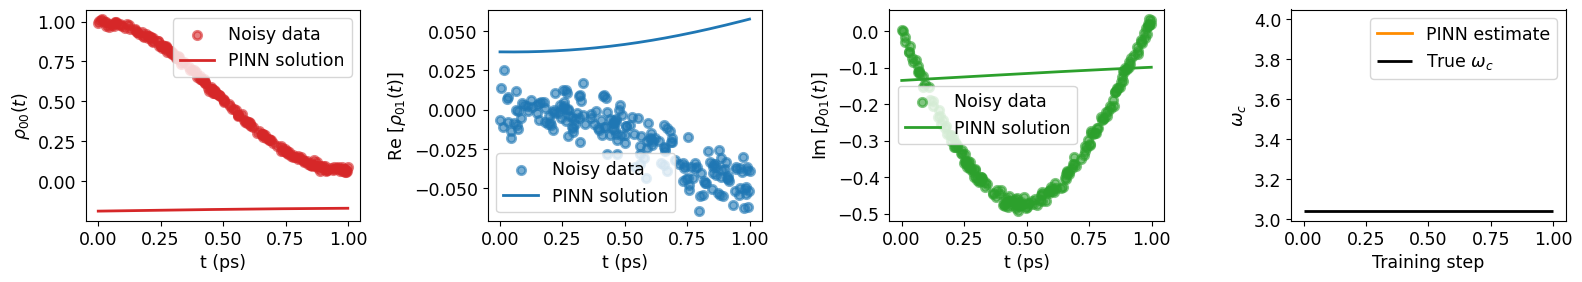

Epoch 500, Total Loss: 0.000873, PDE Loss: 0.006607, Data Loss: 0.000807, v_c = 3.842447280883789


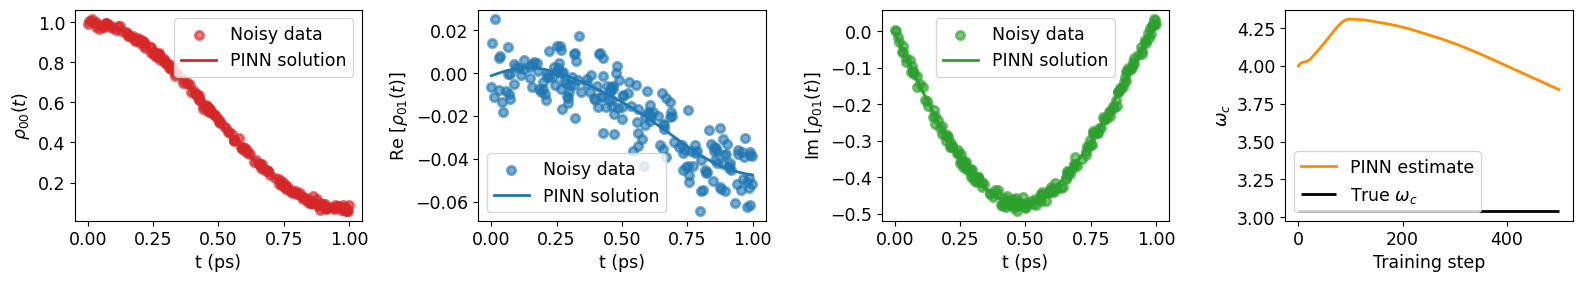

Epoch 1000, Total Loss: 0.000797, PDE Loss: 0.001874, Data Loss: 0.000779, v_c = 3.321103096008301


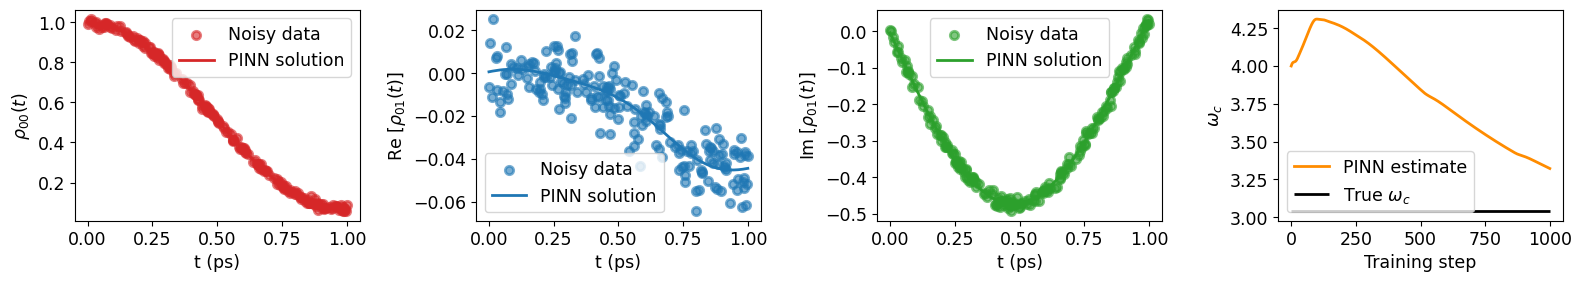

Epoch 1500, Total Loss: 0.000783, PDE Loss: 0.000814, Data Loss: 0.000775, v_c = 3.1136293411254883


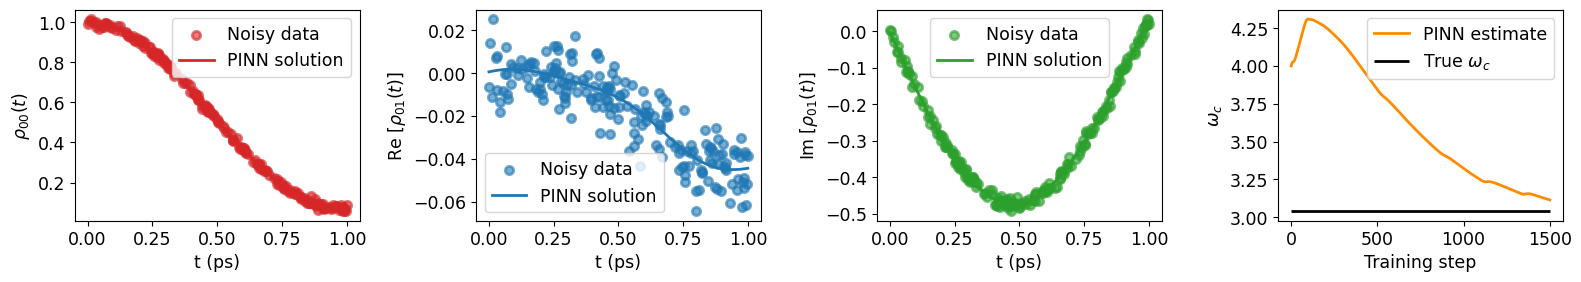

Epoch 2000, Total Loss: 0.001011, PDE Loss: 0.001396, Data Loss: 0.000997, v_c = 3.037851095199585


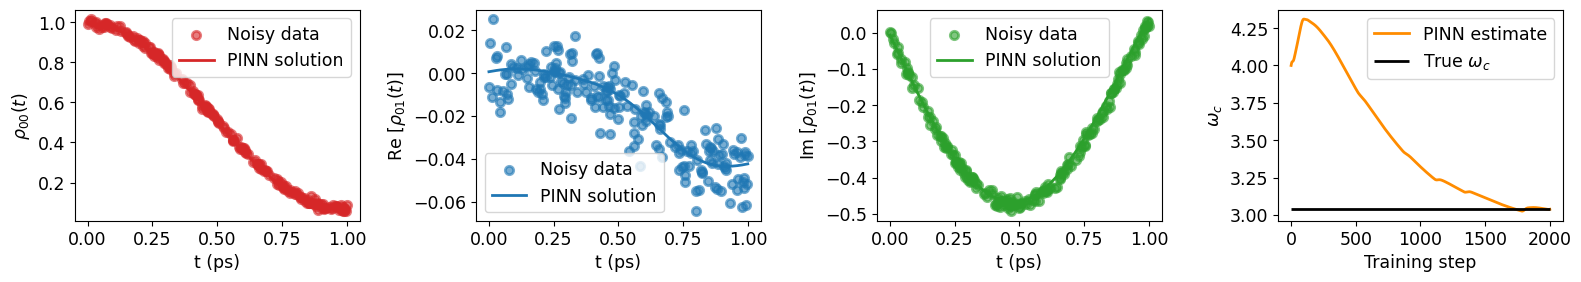

In [23]:
model_inv_2 = train_inv_2(t_obs, rho_obs, v_c0=3.04, alpha=0.126, D=1, T=10, t_intervals=20, M=200, 
                hidden_dim=32, num_layers=4, epochs=2001, lr=5e-3, lam=1e-2, weight_decay=0,
                init_val=torch.tensor(4.0), plot_interval=500, seed=2025)

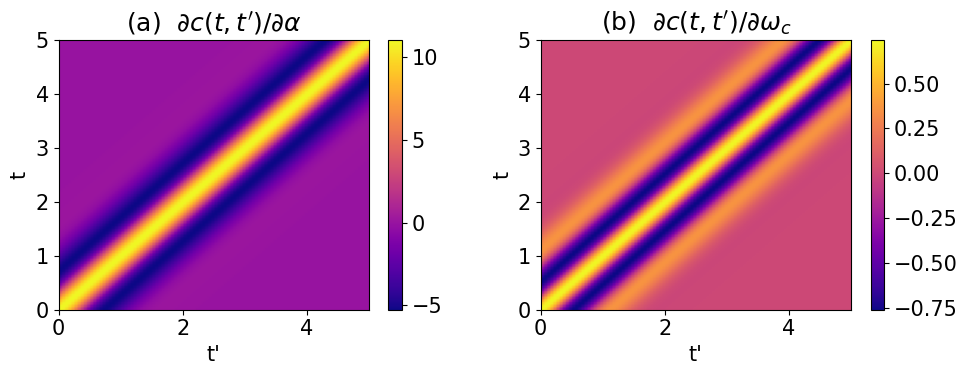

In [1]:
%run sensitivity.py